# MixMatch Training for Binary Classification

In [47]:
import torch
import torchinfo
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [2]:
import mixmatch
import data_utils
import data_pl_utils
import viz_utils
import base_models

In [3]:
import importlib
print(importlib.reload(mixmatch))
print(importlib.reload(data_pl_utils))
print(importlib.reload(data_utils))
print(importlib.reload(viz_utils))
print(importlib.reload(base_models))

<module 'mixmatch' from '/Users/joseph280996/Code/School/L3D/Project/PL/mixmatch.py'>
<module 'data_pl_utils' from '/Users/joseph280996/Code/School/L3D/Project/PL/data_pl_utils.py'>
<module 'data_utils' from '/Users/joseph280996/Code/School/L3D/Project/PL/data_utils.py'>
<module 'viz_utils' from '/Users/joseph280996/Code/School/L3D/Project/PL/viz_utils.py'>
<module 'base_models' from '/Users/joseph280996/Code/School/L3D/Project/PL/base_models.py'>


# Configuration

In [10]:
# device = 'cuda'
device = 'mps'
# device = 'cpu'

In [11]:
PL_DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('../l3d_pn_dataset500PL'))

# 1. Setup Model

# Define the model (example using ResNet18)

In [17]:
import torch.nn as nn
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFeatureExtractor, self).__init__()
        # Load pre-trained ResNet
        resnet = base_models.resnet18(weights=base_models.ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)  # Custom FC layer

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten
        out = self.fc(features)
        return out

In [37]:
model = base_models.PretrainedResNetForPN(
    src_dataset='ImageNet1k',
    arch='ResNet10',
    model_dir='.',
    n_trainable_layers=3,
    n_target_classes=2,  # Binary classification
    seed=42
)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'mps'

Setup complete. Trainable parameter count=133122 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


In [67]:
torchinfo.summary(model, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                 Output Shape       Param #
PretrainedResNetForPN (PretrainedResNetForPN)           [1, 2]             --
├─ResNet (model)                                        [1, 2]             --
│    └─Sequential (features)                            [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                   [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                         [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                         [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                         [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                         [1, 512, 7, 7]     3,673,088
│    │    └─AvgPool2d (final_pool)                      [1, 512, 1, 1]     --
│    └─Linear (output)                                  [1, 2]             1,026
Total params: 4,906,818
Trainable params: 133,122
Non-trainable params: 4,773,696
Total mult-adds (M):

# 2. Prepare Data

# Create initial data loaders

In [15]:
labeled_loader, unlabeled_loader, va_loader, test_loader  = data_utils.make_PN_data_loaders_with_unlabeled(
    root=PL_DATA_DIR,
    batch_size=32,
    n_samples_per_class_trainandvalid=250
)


      splitname   0   1
  train_labeled  49  51
train_unlabeled  51  49
          valid  25  25
           test 125 125


# 3. Initialize MixMatch

In [77]:
mixmatch = mixmatch.MixMatch(
    model=model,
    num_augmentations=3,
    temperature=0.5,
    alpha=0.75,
    lambda_u=50,
    device=device
)

# 4. Train Model

In [79]:
# Define optimizer with only trainable parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model, history = mixmatch.train(
    labeled_loader= labeled_loader,
    unlabeled_loader= unlabeled_loader,
    va_loader=va_loader,
    num_epochs=100,
    learning_rate=0.0001,  # This will be used if optimizer is not provide
    optimizer=optimizer  # Pass the custom optimizer
)


  0%|          | 0/101 [00:05<?, ?it/s]


ValueError: Expected input batch_size (1568) to match target batch_size (32).

# 5. Visualize Results

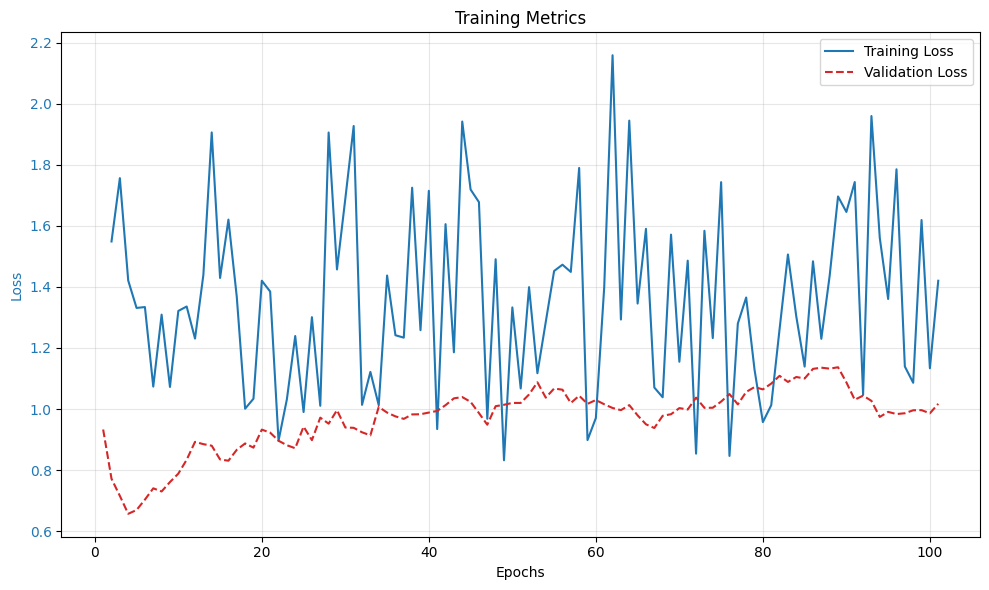

In [71]:
fig = viz_utils.plot_training_metrics(
    training_history=history,
)
plt.show()

# Train code from YU1ut

In [26]:
from utils import WeightEMA
import torch.optim as optim
import torch.nn as nn
import data_utils
import mixmatch2
import wideresnet

In [50]:
print(importlib.reload(wideresnet))
print(importlib.reload(data_utils))
print(importlib.reload(mixmatch2))

<module 'wideresnet' from '/Users/joseph280996/Code/School/L3D/Project/PL/wideresnet.py'>
<module 'data_utils' from '/Users/joseph280996/Code/School/L3D/Project/PL/data_utils.py'>
<module 'mixmatch2' from '/Users/joseph280996/Code/School/L3D/Project/PL/mixmatch2.py'>


## Create Model

In [31]:
def create_model(ema=False):
    model = wideresnet.WRN(num_classes=10)
    model = model.to(device)

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

model = create_model()
ema_model = create_model(ema=True)

## Configuration

In [32]:
LR = 0.002
NUM_EPOCHS = 1024
EMA_DECAY = 0.999

## Train

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ema_optimizer= WeightEMA(model, ema_model, alpha=EMA_DECAY)
start_epoch = 0
mixmatch_trainer = mixmatch2.MixMatch(model, optimizer,
                                    #   ema_optimizer, 
                                      device = device)

# Resume
step = 0
test_accs = []
# Train and val

progressbar = tqdm(range(NUM_EPOCHS + 1))
pbar_info = {}
tr_info = {
    'loss': []
}
va_info = {
    'loss': [],
    'acc': []
}
        
for epoch in progressbar:

    train_loss, train_loss_x, train_loss_u = mixmatch_trainer.train(labeled_loader, unlabeled_loader)
    # _, train_acc = mixmatch_trainer.validate(labeled_loader)
    val_loss, val_acc = mixmatch_trainer.validate(va_loader)
    # test_loss, test_acc = mixmatch_trainer.validate(test_loader, ema_model, criterion, epoch)

    tr_info['loss'].append(train_loss)
    va_info['loss'].append(val_loss)
    va_info['acc'].append(val_acc)

    # save model
    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    pbar_info.update({
        "tr_loss": train_loss,
        "va_loss": val_loss, "va_acc": val_acc
    })
    
    # Update epoch progress bar
    progressbar.set_postfix(pbar_info)

progressbar.close()

print('Best acc:')
print(best_acc)

  0%|          | 0/1025 [00:14<?, ?it/s]


RuntimeError: selected index k out of range